In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import flopy

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_ZN
working_dir = fs.WORKING_DIR_ZN
fs.setup_pest_zn()

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'inschek', 'inschek.exe', 'kzone.ref', 'mf2005', 'mf2005.exe', 'mfnwt', 'mp6', 'mp6.exe', 'mpath.in', 'obs_loc.csv', 'pest++.exe', 'pestchek', 'pestchek.exe', 'pestpp', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'sweep', 'sweep.exe', 'tempchek', 'tempchek.exe', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_zn
FloPy is using the following 

## Given a zone array let's plot it up

In [ ]:
zones = np.loadtxt(os.path.join(working_dir, 'hk.zones'))
plt.imshow(zones)
plt.colorbar()

In [ ]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))


In [ ]:
pst.parameter_data

## run pestpp

In [ ]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 10
pst.write(os.path.join(working_dir,pst_name))
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

In [ ]:
pst.phi

In [ ]:
pst.phi_components

In [ ]:
pst.res.loc[pst.nnz_obs_names,:]

In [ ]:
ax = plt.subplot(111,aspect="equal") 
wl_names = [n for n in pst.nnz_obs_names if n.startswith("c")]
ax.scatter(pst.res.loc[wl_names,"modelled"],pst.res.loc[wl_names,"measured"],marker='.')
ylim,xlim = ax.get_ylim(),ax.get_xlim()
mn = min(ylim[0],xlim[0])
mx = max(ylim[1],xlim[1])
ax.plot([mn,mx],[mn,mx])
ax.set_ylim(mn,mx)
ax.set_xlim(mn,mx)

In [ ]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

In [ ]:
axes = pyemu.helpers.plot_summary_distributions(df_paru,subplots=True)

## Why is ``rch_1`` unaffected by calibration? And why did ``hk_z01`` change so little?

## We can look at the sensitivity

In [ ]:
sens = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".isen")))
sens

## What's up with ``hk_z01``?

In [3]:
# look at ibound
ib = np.loadtxt(os.path.join(working_dir,'ibound_layer_1.ref'))
zones = np.loadtxt(os.path.join(working_dir, 'hk.zones'))


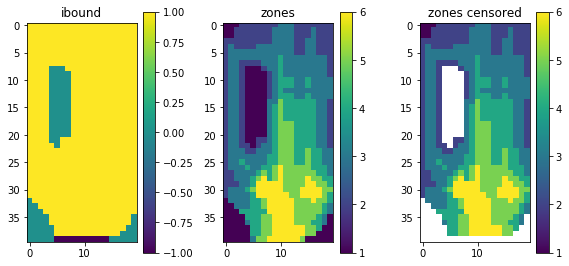

In [4]:
fig = plt.figure(figsize=(8,4))
fig.add_subplot(131)
plt.imshow(ib)
plt.colorbar()
plt.title('ibound')
fig.add_subplot(132)
plt.imshow(zones)
plt.colorbar()
plt.title('zones')
fig.add_subplot(133)
zones[ib!=1]=np.nan
plt.imshow(zones)
plt.title('zones censored')
plt.colorbar()
plt.tight_layout()


In [ ]:
df_predu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)

In [ ]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_predu,subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"k--")
    ax.set_ylim(ylim)

## Now we have some variability in the forecast outcomes...why?

## As far as the "truth" is concerned, we are doing better for most forecasts.  But we are especially bad for the tranvel time forecast - why?  What affects travel time?

## Zone Burner approach

In [ ]:
zones = np.loadtxt(os.path.join(working_dir, 'hk.zones'))

np.unique(zones)

In [ ]:

a = zones.copy()
newk = [100,222,303,444,515,676]

In [ ]:
for cz in np.unique(zones):
    print('updating zone {}'.format(cz))
    a[zones==cz] = newk[int(cz)-1]

In [ ]:
a

In [ ]:
plt.imshow(a)
plt.colorbar()